In [205]:
import emoji
import nltk
import numpy as np
import os
import pandas as pd
import pickle as pk
import re
import string
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision


from autocorrect import Speller
from functools import lru_cache
from matplotlib import pyplot as plt
from collections import Counter
from nltk import collocations 
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem.porter import PorterStemmer as ps
from nltk.stem import WordNetLemmatizer as lem
from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, \
                                            HashingVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from stop_words import get_stop_words
from string import punctuation
from textblob import TextBlob
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

%matplotlib inline

In [99]:
import warnings
warnings.filterwarnings("ignore")

In [100]:
nltk.download('stopwords')
nltk.download('genesis')
nltk.download('punkt')
noise = stopwords.words('russian') + list(punctuation)
punkts = set(string.punctuation)
morph_analyz = MorphAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xiaomi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package genesis to
[nltk_data]     C:\Users\xiaomi\AppData\Roaming\nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xiaomi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [101]:
re_url = re.compile('https?://\S+|www\.\S+')
ABC = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
ru_ABC ='абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'
denial = ['not', 'cannot', 'doesn',  "wasn't", 'nor', 'couldn', 'weren', 
          "won't", "doesn't", 'needn', "isn't", 'against', "couldn't", 
          'aren', 'isn', 'hadn', 'wouldn', "mightn't", "mustn't", "can't", 
          "wouldn't", 'cant', 'didn', "shouldn't",  "don't", "didn't", 
          "hadn't", "needn't", 'shouldn', 'hasnt', "weren't", 'no', "aren't", 
          "hasn't", "haven't", 'нельзя']
stopwords_english = list(set(get_stop_words("en") + 
                             stopwords.words('english') +
                             list(ENGLISH_STOP_WORDS) +
                             ['user']).difference(denial))
stopwords_russian = list(set(get_stop_words("ru") + 
                             stopwords.words('russian') +
                             ['а','у', 'о', '☕', '♡','♥', 'б', 'аж', 'л', 'ха', 'х'
                              '❤', '❤️','❤️', '❤️', '�','✌️', 'd', '❤',
                              'dd', 'p' 'rt', 'щ', 'з', 'эй', 'ибо', '❄️']).difference(denial))

emoji_pattern = \
re.compile("[" 
           u"\U0001F600-\U0001F64F"  # emoticons
           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
           u"\U0001F680-\U0001F6FF"  # transport & map symbols
           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
           u"\U00002500-\U00002BEF"  # chinese char
           u"\U0001F191-\U0001F19A"
           u"\U0001F232-\U0001F236" u"\U0001F238-\U0001F23A" u"\U0001F250-\U0001F251"
           u"\U0001F300-\U0001F30C" u"\U0001F30D-\U0001F30E" u"\U0001F313-\U0001F315"
           u"\U0001F316-\U0001F318" u"\U0001F31D-\U0001F31E" u"\U0001F31F-\U0001F320"
           u"\U0001F32D-\U0001F32F" u"\U0001F330-\U0001F331" u"\U0001F332-\U0001F333"
           u"\U0001F334-\U0001F335" u"\U0001F337-\U0001F34A" u"\U0001F34C-\U0001F34F"
           u"\U0001F351-\U0001F37B" u"\U0001F37E-\U0001F37F" u"\U0001F380-\U0001F393"
           u"\U0001F3A0-\U0001F3C4" u"\U0001F3CF-\U0001F3D3" u"\U0001F3E0-\U0001F3E3"
           u"\U0001F3E5-\U0001F3F0" u"\U0001F3F8-\U0001F407" u"\U0001F409-\U0001F40B"
           u"\U0001F40C-\U0001F40E" u"\U0001F40F-\U0001F410" u"\U0001F411-\U0001F412"
           u"\U0001F417-\U0001F429" u"\U0001F42B-\U0001F43E" u"\U0001F442-\U0001F464"
           u"\U0001F466-\U0001F46B" u"\U0001F46C-\U0001F46D" u"\U0001F46E-\U0001F4AC"
           u"\U0001F4AE-\U0001F4B5" u"\U0001F4B6-\U0001F4B7" u"\U0001F4B8-\U0001F4EB"
           u"\U0001F4EC-\U0001F4ED" u"\U0001F4F0-\U0001F4F4" u"\U0001F4F6-\U0001F4F7"
           u"\U0001F4F9-\U0001F4FC" u"\U0001F4FF-\U0001F502" u"\U0001F504-\U0001F507"
           u"\U0001F50A-\U0001F514" u"\U0001F516-\U0001F52B" u"\U0001F52C-\U0001F52D"
           u"\U0001F52E-\U0001F53D" u"\U0001F54B-\U0001F54E" u"\U0001F550-\U0001F55B"
           u"\U0001F55C-\U0001F567" u"\U0001F595-\U0001F596" u"\U0001F5FB-\U0001F5FF"
           u"\U0001F7E0-\U0001F7EB" u"\U0001F90D-\U0001F90F" u"\U0001F910-\U0001F918"
           u"\U0001F919-\U0001F91E" u"\U0001F920-\U0001F927" u"\U0001F928-\U0001F92F"
           u"\U0001F931-\U0001F932" u"\U0001F933-\U0001F93A" u"\U0001F93C-\U0001F93E"
           u"\U0001F940-\U0001F945" u"\U0001F947-\U0001F94B" u"\U0001F94D-\U0001F94F"
           u"\U0001F950-\U0001F95E" u"\U0001F95F-\U0001F96B" u"\U0001F96C-\U0001F970"
           u"\U0001F973-\U0001F976" u"\U0001F977-\U0001F978" u"\U0001F97C-\U0001F97F"
           u"\U0001F980-\U0001F984" u"\U0001F985-\U0001F991" u"\U0001F992-\U0001F997"
           u"\U0001F998-\U0001F9A2" u"\U0001F9A3-\U0001F9A4" u"\U0001F9A5-\U0001F9AA"
           u"\U0001F9AB-\U0001F9AD" u"\U0001F9AE-\U0001F9AF" u"\U0001F9B0-\U0001F9B9"
           u"\U0001F9BA-\U0001F9BF" u"\U0001F9C1-\U0001F9C2" u"\U0001F9C3-\U0001F9CA"
           u"\U0001F9CD-\U0001F9CF" u"\U0001F9D0-\U0001F9E6" u"\U0001F9E7-\U0001F9FF"
           u"\U0001FA70-\U0001FA73" u"\U0001FA78-\U0001FA7A" u"\U0001FA7B-\U0001FA7C"
           u"\U0001FA80-\U0001FA82" u"\U0001FA83-\U0001FA86" u"\U0001FA90-\U0001FA95"
           u"\U0001FA96-\U0001FAA8" u"\U0001FAA9-\U0001FAAC" u"\U0001FAB0-\U0001FAB6"
           u"\U0001FAB7-\U0001FABA" u"\U0001FAC0-\U0001FAC2" u"\U0001FAC3-\U0001FAC5"
           u"\U0001FAD0-\U0001FAD6" u"\U0001FAD7-\U0001FAD9" u"\U0001FAE0-\U0001FAE7"
           u"\U0001FAF0-\U0001FAF6" u"\U00002702-\U000027B0" u"\U00002702-\U000027B0" 
           u"\U000024C2-\U0001F251" u"\U0001f926-\U0001f937" u"\U00010000-\U0010ffff"
           u"\u231A-\u231B" u"\u200d" u"\u23E9-\u23EC" u"\u25FD-\u25FE" u"\u2600-\u2B55" 
           u"\ufe0f"  # dingbats
           u"\u3030" "]+", flags=re.UNICODE)

apostrophe_dict = {
            "ain`t": "am not / are not",
            "aren`t": "are not / am not",
            "can`t": "cannot",
            "can`t`ve": "cannot have",
            "`cause": "because",
            "could`ve": "could have",
            "couldn`t": "could not",
            "couldn`t`ve": "could not have",
            "didn`t": "did not",
            "doesn`t": "does not",
            "don`t": "do not",
            "hadn`t": "had not",
            "hadn`t've": "had not have",
            "hasn`t": "has not",
            "haven`t": "have not",
            "he`d": "he had / he would",
            "he`d`ve": "he would have",
            "he`ll": "he shall / he will",
            "he`ll`ve": "he shall have / he will have",
            "he`s": "he has / he is",
            "how`d": "how did",
            "how`d'y": "how do you",
            "how`ll": "how will",
            "how`s": "how has / how is",
            "i`d": "I had / I would",
            "i`d`ve": "I would have",
            "i`ll": "I shall / I will",
            "i`ll`ve": "I shall have / I will have",
            "i`m": "I am",
            "i`ve": "I have",
            "isn`t": "is not",
            "it`d": "it had / it would",
            "it`d`ve": "it would have",
            "it`ll": "it shall / it will",
            "it`ll`ve": "it shall have / it will have",
            "it`s": "it has / it is",
            "let`s": "let us",
            "ma`am": "madam",
            "mayn`t": "may not",
            "might`ve": "might have",
            "mightn`t": "might not",
            "mightn`t`ve": "might not have",
            "must`ve": "must have",
            "mustn`t": "must not",
            "mustn`t`ve": "must not have",
            "needn`t": "need not",
            "needn`t`ve": "need not have",
            "o`clock": "of the clock",
            "oughtn`t": "ought not",
            "oughtn`t`ve": "ought not have",
            "shan`t": "shall not",
            "sha`n`t": "shall not",
            "shan`t`ve": "shall not have",
            "she`d": "she had / she would",
            "she`d`ve": "she would have",
            "she`ll": "she shall / she will",
            "she`ll`ve": "she shall have / she will have",
            "she`s": "she has / she is",
            "should`ve": "should have",
            "shouldn`t": "should not",
            "shouldn`t`ve": "should not have",
            "so`ve": "so have",
            "so`s": "so as / so is",
            "that`d": "that would / that had",
            "that`d've": "that would have",
            "that`s": "that has / that is",
            "there`d": "there had / there would",
            "there`d`ve": "there would have",
            "there`s": "there has / there is",
            "they`d": "they had / they would",
            "they`d`ve": "they would have",
            "they`ll": "they shall / they will",
            "they`ll`ve": "they shall have / they will have",
            "they`re": "they are",
            "they`ve": "they have",
            "to`ve": "to have",
            "wasn`t": "was not",
            "we`d": "we had / we would",
            "we`d`ve": "we would have",
            "we`ll": "we will",
            "we`ll`ve": "we will have",
            "we`re": "we are",
            "we`ve": "we have",
            "weren`t": "were not",
            "what`ll": "what shall / what will",
            "what`ll`ve": "what shall have / what will have",
            "what`re": "what are",
            "what`s": "what has / what is",
            "what`ve": "what have",
            "when`s": "when has / when is",
            "when`ve": "when have",
            "where`d": "where did",
            "where`s": "where has / where is",
            "where`ve": "where have",
            "who`ll": "who shall / who will",
            "who`ll`ve": "who shall have / who will have",
            "who`s": "who has / who is",
            "who`ve": "who have",
            "why`s": "why has / why is",
            "why`ve": "why have",
            "will`ve": "will have",
            "won`t": "will not",
            "won`t`ve": "will not have",
            "would`ve": "would have",
            "wouldn`t": "would not",
            "wouldn`t`ve": "would not have",
            "y`all": "you all",
            "y`all`d": "you all would",
            "y`all`d`ve": "you all would have",
            "y`all`re": "you all are",
            "y`all`ve": "you all have",
            "you`d": "you had / you would",
            "you`d`ve": "you would have",
            "you`ll": "you shall / you will",
            "you`ll`ve": "you shall have / you will have",
            "you`re": "you are",
            "you`ve": "you have"
        }

@lru_cache(maxsize=2048)
def text_preprocess_light(text):
    text = str(text)
    text = re_url.sub('', text)
    nicks = re.findall(r'@[\w]*', text)
    for nick in nicks:
        text = re.sub(nick, ' ', text)
    re_html = re.compile('<.*?>')
    text = re_html.sub(r'', text)
    text = emoji_pattern.sub(r'',text)
    for word in text.split():
        if word.lower() in apostrophe_dict:
            text = re.sub(word, apostrophe_dict[word.lower()], text)
    text = ' '.join([word for word in text.split() if len(word) > 1])
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'[^а-яА-Я]', ' ', text)
    text = re.sub(r'\s\s+', ' ', text)
    text = re.sub('не\s', 'не', text)
    text = re.sub('нет\s', 'нет', text)
    text = ' '.join([word for word in text.split() if len(word) > 2])
    text = text.lower()
#     text = TextBlob(text).correct().string
    text = [morph_analyz.parse(word)[0].normal_form for word in text.split() if word not in stopwords_russian] 
                                                                           # if word not in stopwords_english
    return " ".join(text)

In [102]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [103]:
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


In [104]:
tqdm.pandas()
df['text_pre'] = df['text'].progress_apply(text_preprocess_light)

100%|█████████████████████████████████████████████████████████████████████████| 226834/226834 [12:54<00:00, 292.84it/s]


In [105]:
df.tail()

,text,label,text_pre
111918,Но не каждый хочет что то исправлять:( http://...,negative,некаждый хотеть исправлять
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative,скучать вправлять мозг равно скучать
111920,"Вот и в школу, в говно это идти уже надо(",negative,школа говно идти
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative,тауриэль негрусть обнять
111922,Такси везет меня на работу. Раздумываю приплат...,negative,такси везти работа раздумывать приплатить втащ...


In [106]:
df.insert(1, 'text_token', [word_tokenize(tweet) for tweet in df['text']], allow_duplicates=True)

In [107]:
df

,text,text_token,label,text_pre
0,"@first_timee хоть я и школота, но поверь, у на...","[@, first_timee, хоть, я, и, школота, ,, но, п...",positive,школотый поверь самый общество профилировать п...
1,"Да, все-таки он немного похож на него. Но мой ...","[Да, ,, все-таки, он, немного, похож, на, него...",positive,таки похожий мальчик равно
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,"[RT, @, KatiaCheh, :, Ну, ты, идиотка, ), я, и...",positive,идиотка испугаться
3,"RT @digger2912: ""Кто то в углу сидит и погибае...","[RT, @, digger2912, :, ``, Кто, то, в, углу, с...",positive,угол сидеть погибать голод порция взять жрать ...
4,@irina_dyshkant Вот что значит страшилка :D\nН...,"[@, irina_dyshkant, Вот, что, значит, страшилк...",positive,страшилка блин посмотреть часть создаться ощущ...
...,...,...,...,...
111918,Но не каждый хочет что то исправлять:( http://...,"[Но, не, каждый, хочет, что, то, исправлять, :...",negative,некаждый хотеть исправлять
111919,скучаю так :-( только @taaannyaaa вправляет мо...,"[скучаю, так, :, -, (, только, @, taaannyaaa, ...",negative,скучать вправлять мозг равно скучать
111920,"Вот и в школу, в говно это идти уже надо(","[Вот, и, в, школу, ,, в, говно, это, идти, уже...",negative,школа говно идти
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...","[RT, @, _Them__, :, @, LisaBeroud, Тауриэль, ,...",negative,тауриэль негрусть обнять


In [108]:
stem_tweet_token =[]
for tokens in df['text_token']:
    stem_token =  [ps().stem(token) for token in tokens]
    stem_tweet_token.append(stem_token)

In [109]:
df.insert(2, 'text_stemmed', stem_tweet_token, allow_duplicates=True)

In [110]:
df

,text,text_token,text_stemmed,label,text_pre
0,"@first_timee хоть я и школота, но поверь, у на...","[@, first_timee, хоть, я, и, школота, ,, но, п...","[@, first_time, хоть, я, и, школота, ,, но, по...",positive,школотый поверь самый общество профилировать п...
1,"Да, все-таки он немного похож на него. Но мой ...","[Да, ,, все-таки, он, немного, похож, на, него...","[да, ,, все-таки, он, немного, похож, на, него...",positive,таки похожий мальчик равно
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,"[RT, @, KatiaCheh, :, Ну, ты, идиотка, ), я, и...","[rt, @, katiacheh, :, ну, ты, идиотка, ), я, и...",positive,идиотка испугаться
3,"RT @digger2912: ""Кто то в углу сидит и погибае...","[RT, @, digger2912, :, ``, Кто, то, в, углу, с...","[rt, @, digger2912, :, ``, кто, то, в, углу, с...",positive,угол сидеть погибать голод порция взять жрать ...
4,@irina_dyshkant Вот что значит страшилка :D\nН...,"[@, irina_dyshkant, Вот, что, значит, страшилк...","[@, irina_dyshk, вот, что, значит, страшилка, ...",positive,страшилка блин посмотреть часть создаться ощущ...
...,...,...,...,...,...
111918,Но не каждый хочет что то исправлять:( http://...,"[Но, не, каждый, хочет, что, то, исправлять, :...","[но, не, каждый, хочет, что, то, исправлять, :...",negative,некаждый хотеть исправлять
111919,скучаю так :-( только @taaannyaaa вправляет мо...,"[скучаю, так, :, -, (, только, @, taaannyaaa, ...","[скучаю, так, :, -, (, только, @, taaannyaaa, ...",negative,скучать вправлять мозг равно скучать
111920,"Вот и в школу, в говно это идти уже надо(","[Вот, и, в, школу, ,, в, говно, это, идти, уже...","[вот, и, в, школу, ,, в, говно, это, идти, уже...",negative,школа говно идти
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...","[RT, @, _Them__, :, @, LisaBeroud, Тауриэль, ,...","[rt, @, _them__, :, @, lisaberoud, тауриэль, ,...",negative,тауриэль негрусть обнять


In [111]:
lemma_tweet_token =[]
for tokens in df['text_stemmed']:
    lemma_token =  [lem().lemmatize(token) for token in tokens]
    lemma_tweet_token.append(lemma_token)

In [112]:
df.insert(3, 'text_lemmatized', lemma_tweet_token, allow_duplicates=True)

In [113]:
df

,text,text_token,text_stemmed,text_lemmatized,label,text_pre
0,"@first_timee хоть я и школота, но поверь, у на...","[@, first_timee, хоть, я, и, школота, ,, но, п...","[@, first_time, хоть, я, и, школота, ,, но, по...","[@, first_time, хоть, я, и, школота, ,, но, по...",positive,школотый поверь самый общество профилировать п...
1,"Да, все-таки он немного похож на него. Но мой ...","[Да, ,, все-таки, он, немного, похож, на, него...","[да, ,, все-таки, он, немного, похож, на, него...","[да, ,, все-таки, он, немного, похож, на, него...",positive,таки похожий мальчик равно
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,"[RT, @, KatiaCheh, :, Ну, ты, идиотка, ), я, и...","[rt, @, katiacheh, :, ну, ты, идиотка, ), я, и...","[rt, @, katiacheh, :, ну, ты, идиотка, ), я, и...",positive,идиотка испугаться
3,"RT @digger2912: ""Кто то в углу сидит и погибае...","[RT, @, digger2912, :, ``, Кто, то, в, углу, с...","[rt, @, digger2912, :, ``, кто, то, в, углу, с...","[rt, @, digger2912, :, ``, кто, то, в, углу, с...",positive,угол сидеть погибать голод порция взять жрать ...
4,@irina_dyshkant Вот что значит страшилка :D\nН...,"[@, irina_dyshkant, Вот, что, значит, страшилк...","[@, irina_dyshk, вот, что, значит, страшилка, ...","[@, irina_dyshk, вот, что, значит, страшилка, ...",positive,страшилка блин посмотреть часть создаться ощущ...
...,...,...,...,...,...,...
111918,Но не каждый хочет что то исправлять:( http://...,"[Но, не, каждый, хочет, что, то, исправлять, :...","[но, не, каждый, хочет, что, то, исправлять, :...","[но, не, каждый, хочет, что, то, исправлять, :...",negative,некаждый хотеть исправлять
111919,скучаю так :-( только @taaannyaaa вправляет мо...,"[скучаю, так, :, -, (, только, @, taaannyaaa, ...","[скучаю, так, :, -, (, только, @, taaannyaaa, ...","[скучаю, так, :, -, (, только, @, taaannyaaa, ...",negative,скучать вправлять мозг равно скучать
111920,"Вот и в школу, в говно это идти уже надо(","[Вот, и, в, школу, ,, в, говно, это, идти, уже...","[вот, и, в, школу, ,, в, говно, это, идти, уже...","[вот, и, в, школу, ,, в, говно, это, идти, уже...",negative,школа говно идти
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...","[RT, @, _Them__, :, @, LisaBeroud, Тауриэль, ,...","[rt, @, _them__, :, @, lisaberoud, тауриэль, ,...","[rt, @, _them__, :, @, lisaberoud, тауриэль, ,...",negative,тауриэль негрусть обнять


In [122]:
x_train, x_test, y_train, y_test = train_test_split(df.text_pre, df.label)

In [123]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:30]

2870536


['first_timee',
 'хоть',
 'я',
 'и',
 'школота',
 'но',
 'поверь',
 'у',
 'нас',
 'то',
 'же',
 'самое',
 'D',
 'общество',
 'профилирующий',
 'предмет',
 'типа',
 'Да',
 'все-таки',
 'он',
 'немного',
 'похож',
 'на',
 'него',
 'Но',
 'мой',
 'мальчик',
 'все',
 'равно',
 'лучше']

In [124]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:30]

[('не', 69472),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860),
 ('...', 22363),
 ('меня', 20656),
 ('у', 18928),
 ('как', 18279),
 ('так', 16839),
 ('D', 16575),
 ('это', 16542),
 ('мне', 16337),
 ('все', 14763),
 ('ты', 13412),
 ('но', 12949),
 ("''", 12471),
 ('Я', 12315),
 ('``', 11467),
 ('то', 11432),
 ('..', 11392),
 ('по', 11294),
 ('уже', 10180),
 ('за', 10038),
 ('же', 9628)]

In [125]:
len(freq_dict_sorted)

351123

## Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

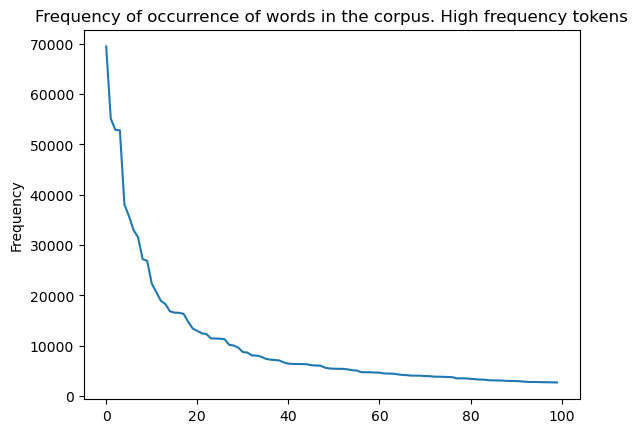

In [126]:
# High frequency tokens
first_part_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.title('Frequency of occurrence of words in the corpus. High frequency tokens')
plt.ylabel('Frequency')
plt.plot(first_part_freqs)
plt.show()

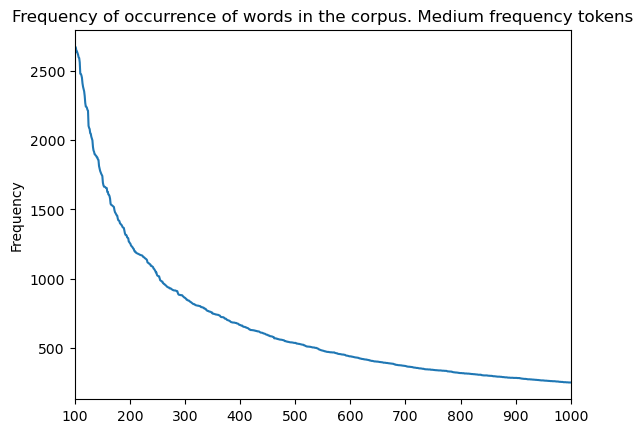

In [127]:
# Мedium frequency tokens
plt.title('Frequency of occurrence of words in the corpus. Мedium frequency tokens')
plt.ylabel('Frequency')
second_part_freqs = [freq for word, freq in freq_dict_sorted[100:1000]]
plt.plot(list(range(100,1000)), second_part_freqs)
plt.xlim(100, 1000)
plt.show()

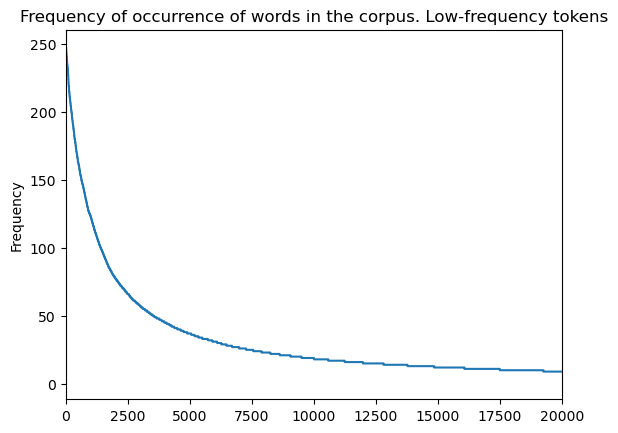

In [128]:
# low-frequency tokens
plt.title('Frequency of occurrence of words in the corpus. Low-frequency tokens')
plt.ylabel('Frequency')
third_part_freqs = [freq for word, freq in freq_dict_sorted[1000:]]
plt.plot(third_part_freqs)
plt.xlim(0, 20000)
plt.show()

In [129]:
high_freq_tokens = [word for word, freq in freq_dict_sorted[:100]]
medium_freq_tokens  = [word for word, freq in freq_dict_sorted[100:1000]]
low_freq_tokens = [word for word, freq in freq_dict_sorted[1000:]]

In [130]:
len(high_freq_tokens), len(medium_freq_tokens), len(low_freq_tokens)

(100, 900, 350123)

##### High frequency tokens

In [131]:
%%time
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=medium_freq_tokens+low_freq_tokens)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.43      0.67      0.52     17630
    positive       0.80      0.59      0.68     39079

    accuracy                           0.62     56709
   macro avg       0.61      0.63      0.60     56709
weighted avg       0.68      0.62      0.63     56709

Wall time: 2min 26s


##### Medium frequency tokens

In [132]:
%%time
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=high_freq_tokens+low_freq_tokens)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.56      0.70      0.62     22185
    positive       0.77      0.64      0.70     34524

    accuracy                           0.66     56709
   macro avg       0.66      0.67      0.66     56709
weighted avg       0.68      0.66      0.67     56709

Wall time: 2min 22s


##### Low-frequency tokens

In [133]:
%%time
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=high_freq_tokens+medium_freq_tokens)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.71      0.69      0.70     28642
    positive       0.69      0.71      0.70     28067

    accuracy                           0.70     56709
   macro avg       0.70      0.70      0.70     56709
weighted avg       0.70      0.70      0.70     56709

Wall time: 1min 21s


##### Вывод:
Лучшие результаты достигаются на низкочастотных токенах.

##### With punctuation (o важности эксплоративного анализа)

In [136]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

In [137]:
%%time
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=stopwords.words('russian'))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     28033
    positive       1.00      1.00      1.00     28676

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709

Wall time: 1min 5s


## Задание 2.

найти фичи с наибольшей значимостью, и вывести их

In [150]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet)]
print(len(corpus))
corpus[:30]

4027060


['@',
 'first_timee',
 'хоть',
 'я',
 'и',
 'школота',
 ',',
 'но',
 'поверь',
 ',',
 'у',
 'нас',
 'то',
 'же',
 'самое',
 ':',
 'D',
 'общество',
 'профилирующий',
 'предмет',
 'типа',
 ')',
 'Да',
 ',',
 'все-таки',
 'он',
 'немного',
 'похож',
 'на',
 'него']

In [154]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:30]

[('(', 212404),
 (')', 194005),
 (',', 188295),
 (':', 177675),
 ('@', 149978),
 ('не', 69472),
 ('!', 66923),
 ('.', 57595),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('?', 35955),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860),
 ('...', 22363),
 ('меня', 20656),
 ('#', 19608),
 ('у', 18928),
 ('как', 18279),
 ('-', 17958),
 ('так', 16839),
 ('D', 16575),
 ('это', 16542),
 ('мне', 16337),
 ('все', 14763),
 ('ты', 13412)]

In [156]:
cool_token = freq_dict_sorted[:10]
cool_token

[('(', 212404),
 (')', 194005),
 (',', 188295),
 (':', 177675),
 ('@', 149978),
 ('не', 69472),
 ('!', 66923),
 ('.', 57595),
 ('и', 55166),
 ('в', 52902)]

Посмотрим, как один из супер-значительных токенов справится с классификацией безо всякого машинного обучения:

In [157]:
cool_token = freq_dict_sorted[1][0]
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      0.85      0.92     32894
    positive       0.83      1.00      0.91     23815

    accuracy                           0.91     56709
   macro avg       0.92      0.93      0.91     56709
weighted avg       0.93      0.91      0.91     56709



## Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера 

3) убедиться что для сетки нет переобучения

In [158]:
x_train, x_test, y_train, y_test = train_test_split(df.text_pre, df.label)

In [161]:
corpus = [token for tweet in df.text_pre for token in word_tokenize(tweet) if token not in punctuation]

In [162]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])

In [163]:
high_freq_tokens = [word for word, freq in freq_dict_sorted[:100]]
medium_freq_tokens  = [word for word, freq in freq_dict_sorted[100:1000]]
low_freq_tokens = [word for word, freq in freq_dict_sorted[1000:]]

In [164]:
%%time
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=high_freq_tokens+medium_freq_tokens)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.71      0.64      0.67     31210
    positive       0.60      0.68      0.64     25499

    accuracy                           0.66     56709
   macro avg       0.66      0.66      0.66     56709
weighted avg       0.66      0.66      0.66     56709

Wall time: 33.6 s


In [167]:
%%time
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=high_freq_tokens+medium_freq_tokens)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.70      0.64      0.67     30405
    positive       0.62      0.68      0.65     26304

    accuracy                           0.66     56709
   macro avg       0.66      0.66      0.66     56709
weighted avg       0.66      0.66      0.66     56709

Wall time: 32.2 s


In [189]:
%%time
for n_features in range(1000, 20000, 1000):
    vec = HashingVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, 
                            stop_words=high_freq_tokens+medium_freq_tokens, 
                            n_features=n_features)
    bow = vec.fit_transform(x_train)
    clf = LogisticRegression(random_state=42)
    clf.fit(bow, y_train)
    pred = clf.predict(vec.transform(x_test))
    print(f'n_features = {n_features}\n {classification_report(pred, y_test)}')

n_features = 1000
               precision    recall  f1-score   support

    negative       0.47      0.55      0.51     24070
    positive       0.62      0.55      0.58     32639

    accuracy                           0.55     56709
   macro avg       0.55      0.55      0.54     56709
weighted avg       0.56      0.55      0.55     56709

n_features = 2000
               precision    recall  f1-score   support

    negative       0.49      0.57      0.53     24326
    positive       0.63      0.56      0.60     32383

    accuracy                           0.57     56709
   macro avg       0.56      0.57      0.56     56709
weighted avg       0.57      0.57      0.57     56709

n_features = 3000
               precision    recall  f1-score   support

    negative       0.50      0.57      0.54     24425
    positive       0.64      0.57      0.60     32284

    accuracy                           0.57     56709
   macro avg       0.57      0.57      0.57     56709
weighted avg     

In [190]:
%%time
vec = HashingVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, 
                        stop_words=high_freq_tokens+medium_freq_tokens, 
                        n_features=17000)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(f'n_features = 17000\n {classification_report(pred, y_test)}')

n_features = 19000
               precision    recall  f1-score   support

    negative       0.66      0.61      0.63     30082
    positive       0.59      0.64      0.62     26627

    accuracy                           0.62     56709
   macro avg       0.62      0.63      0.62     56709
weighted avg       0.63      0.62      0.62     56709

Wall time: 29.6 s


In [206]:
torch.cuda.is_available()

True

In [207]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [208]:
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, )
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [209]:
class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [294]:
#Training
epochs = 10
batch_size = 512
print_batch_n = 100
max_len = 10
max_words = 2000

In [281]:
train, test = train_test_split(df, test_size=0.2)

In [282]:
len(train)

181467

In [283]:
train = train.sample(frac=.02)
test = test.sample(frac=.02)

In [285]:
len(train), len(test)

(3629, 907)

In [286]:
def text_to_sequence(text, maxlen):
    result = []
    for word in text:
        if word in freq_dict_sorted:
            result.append(freq_dict_sorted[word])
    padding = [0] * (maxlen - len(result))
    return result[-maxlen:] + padding

In [287]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in tqdm(train['text_pre'])])
x_test = np.asarray([text_to_sequence(text, max_len) for text in tqdm(test['text_pre'])])

100%|████████████████████████████████████████████████████████████████████████████████| 907/907 [03:39<00:00,  4.12it/s]

Wall time: 19min 21s


In [288]:
for lab in tqdm(train['label']):
    if lab == 'positive':
        df['label_num'] = 0
    else:
        df['label_num'] = 1

100%|████████████████████████████████████████████████████████████████████████████| 3629/3629 [00:02<00:00, 1373.44it/s]


In [289]:
for lab in tqdm(test['label']):
    if lab == 'positive':
        df['label_num'] = 0
    else:
        df['label_num'] = 1

100%|██████████████████████████████████████████████████████████████████████████████| 907/907 [00:00<00:00, 1332.74it/s]


In [291]:
train_dataset = DataWrapper(x_train, train['label_num'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_test, test['label_num'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [292]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 10])
torch.Size([512])
tensor(1)


In [295]:
gru_init = GRUFixedLen(max_words, 128, max_len, use_last=False)
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [296]:
print(gru_init)
print("Parameters:", sum([param.nelement() for param in gru_init.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (gru): GRU(128, 10, num_layers=2, batch_first=True)
  (linear): Linear(in_features=10, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 260871


In [297]:
gru_init = gru_init.to(device)
gru_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []
train_acc_history =[]
val_acc_history = []


for epoch in range(epochs): 
    gru_init.train() 
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = gru_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    gru_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    train_acc_history.append(running_right / running_items)
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = gru_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    val_acc_history.append(test_running_right / test_running_total)
            
print('Training is finished!')

Epoch [1/10]. Step [8/8]. Loss: 0.603. Acc: 1.000. Test loss: 0.599. Test acc: 1.000
Epoch [2/10]. Step [8/8]. Loss: 0.565. Acc: 1.000. Test loss: 0.560. Test acc: 1.000
Epoch [3/10]. Step [8/8]. Loss: 0.524. Acc: 1.000. Test loss: 0.519. Test acc: 1.000
Epoch [4/10]. Step [8/8]. Loss: 0.480. Acc: 1.000. Test loss: 0.474. Test acc: 1.000
Epoch [5/10]. Step [8/8]. Loss: 0.431. Acc: 1.000. Test loss: 0.424. Test acc: 1.000
Epoch [6/10]. Step [8/8]. Loss: 0.377. Acc: 1.000. Test loss: 0.370. Test acc: 1.000
Epoch [7/10]. Step [8/8]. Loss: 0.322. Acc: 1.000. Test loss: 0.315. Test acc: 1.000
Epoch [8/10]. Step [8/8]. Loss: 0.269. Acc: 1.000. Test loss: 0.262. Test acc: 1.000
Epoch [9/10]. Step [8/8]. Loss: 0.221. Acc: 1.000. Test loss: 0.216. Test acc: 1.000
Epoch [10/10]. Step [8/8]. Loss: 0.182. Acc: 1.000. Test loss: 0.178. Test acc: 1.000
Training is finished!


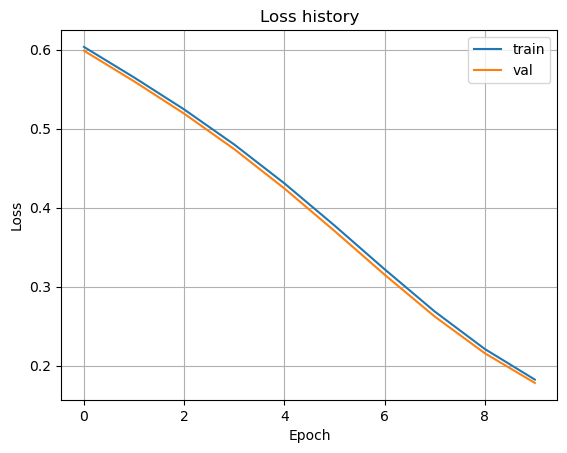

In [298]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='val')
plt.legend();

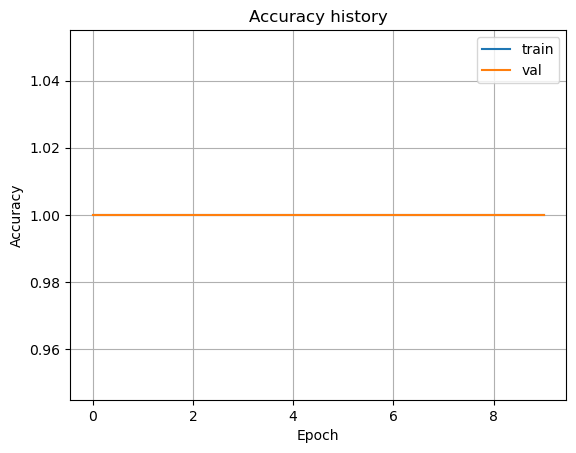

In [299]:
plt.title('Accuracy history')
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(torch.stack(train_acc_history).cpu(), label='train')
plt.plot(torch.stack(val_acc_history).cpu(), label='val')
plt.legend();